In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

2024-04-04 20:58:09.634775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 20:58:09.668139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TEST GPU

In [3]:
tf.config.list_logical_devices()

2024-04-04 20:58:11.073903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:58:11.079725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:58:11.079760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:58:11.084256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:58:11.084289: I external/local_xla/xla/stream_executor

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Get data path

In [4]:
# DATASET_PATH = 'data/mini_speech_commands'
DATASET_PATH = 'data/micro_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

## Get spectogram function from before

In [5]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
    
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

## Run the model with a specified waveform path

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 124, 129,   1], dtype=int32), 'shape_signature': array([ -1, 124, 129,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 14, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[-1.0906684   2.2243214  -0.6540617  -0.89790946 -1.4386169 ]]


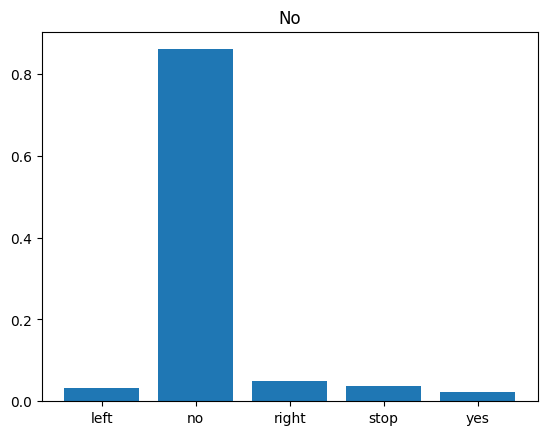

In [9]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter('ligther_model.tflite')
interpreter.allocate_tensors()

# my_signature = interpreter.get_signature_runner()
# print(my_signature)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Get waveform
x = data_dir/'no/01bb6a2a_nohash_0.wav' #NO TEST
# x = data_dir/'right/012c8314_nohash_1.wav' #RIGHT TEST
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = x
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

# x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
x_labels = ['left', 'no', 'right', 'stop', 'yes']

plt.bar(x_labels, tf.nn.softmax(output_data[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))